# Векторные представления для описаний ингредиентов
## Математические методы анализа текстов, 2020
## Попов Артём

In [1]:
# считывание данных
import json

# удобный словарь для подсчёта количества появлений
from collections import Counter

# логгирование цикла
from tqdm.notebook import tqdm

# регулярные выражения для предобработки
import re

# графики
import matplotlib.pyplot as plt

Загружаем датасет с рецептами (https://www.kaggle.com/venkataganesh/recipes-clean-dataset):

In [2]:
with open('bbc_food.json', 'r') as f:
    food_table = json.load(f)

In [4]:
food_table[0].keys()

dict_keys(['total_ratings', 'serving', 'recipe_image', 'prep_time', 'ingredients', 'url', 'title', 'uniq_id', 'source', 'cooking_time', 'chef_url', 'skill_level', 'crawled_at', 'prep_methods', 'chef_name'])

Мы хотим выучить векторные представления для ингредиентов блюд. Посмотрим, сколько уникальных ингредиентов:

In [5]:
all_food_names = Counter()

for one_recipe in tqdm(food_table):
    all_food_names.update(one_recipe['ingredients'])
len(all_food_names)

60484

Довольно много, посмотрим на них:

In [7]:
all_food_names.most_common(10)

[('1 tbsp olive oil', 992),
 ('2 tbsp olive oil', 897),
 ('1 garlic clove, crushed', 448),
 ('2 garlic cloves, crushed', 425),
 ('3 tbsp olive oil', 394),
 ('1 tsp vanilla extract', 382),
 ('50g butter', 343),
 ('25g butter', 333),
 ('1 egg, beaten', 317),
 ('1 onion, finely chopped', 266)]

Проведём предобработку имён, удалим разные модификаторы количества/размера/объёма, а также уберём дополнительное описание после запятой:

In [7]:
def preprocess_food_name(one_food):
    one_food = one_food.lower()
    one_food = re.sub('^([0-9½¼-]+)\s(tbsp|tsp)', '', one_food).strip()
    one_food = re.sub('^[0-9]+(g|ml| large|l)', '', one_food).strip()
    one_food = re.sub('^[0-9½¼-]+', '', one_food).strip()
    one_food = re.sub(',.*$', '', one_food).strip()
    return one_food

In [8]:
all_food_names = Counter()

for one_recipe in tqdm(food_table):
    for one_food in one_recipe['ingredients']:
        one_food = preprocess_food_name(one_food)
        all_food_names.update([one_food])

len(all_food_names)

27003

Теперь их гораздо меньше.

Запомним все нечастотные (их большинство):

In [9]:
bad_names = set()
for name, name_count in all_food_names.items():
    if name_count < 5:
        bad_names.add(name)

len(bad_names)

24603

А теперь создаём датасет. Для начала создадим датасет для решения задачи при помощи библиотеки gensim.

In [12]:
re.split('[\s-]', 'one-two three')

['one', 'two', 'three']

In [13]:
food_dataset_for_embeddings = []

for one_recipe in tqdm(food_table):
    current_recipe_entities = []
    for one_food in one_recipe['ingredients']:
        one_food = preprocess_food_name(one_food)
        if one_food not in bad_names:
            # for gensim
            current_recipe_entities.append("_".join(re.split('[\s-]', one_food)))            
        else:
            # for gensim
            current_recipe_entities.append('UNK')
    food_dataset_for_embeddings.append(current_recipe_entities)

Один документ - ингредиенты одного блюда, редкие ингредиенты заменены на UNK:

In [17]:
food_dataset_for_embeddings[5]

['dried_lasagne_sheets',
 'sunflower_oil',
 'onion',
 'UNK',
 'garlic_cloves',
 'tub_ricotta',
 'cheddar',
 'UNK']

Обучим модель Word2Vec и посмотрим на результаты:

In [18]:
from gensim.models import Word2Vec

In [19]:
model = Word2Vec(
    food_dataset_for_embeddings,
    sg=0,
    hs=1,
    window=10,
    min_count=5,
    iter=20,
    size=40, # не нужен большой, маленький словарь
)

In [20]:
model.most_similar('olive_oil')

C:\Users\artem\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('olive_or_rapeseed_oil', 0.7239720821380615),
 ('extra_virgin_olive_oil', 0.6861706972122192),
 ('sunflower_oil', 0.6393294334411621),
 ('½_tbsp_olive_oil', 0.6144692897796631),
 ('roasted_peppers_from_a_jar', 0.6043404340744019),
 ('jar_passata', 0.6004095673561096),
 ('vegetable_oil_or_sunflower_oil', 0.597752034664154),
 ('pack_flat_leaf_parsley', 0.5970256328582764),
 ('rapeseed_oil', 0.596339225769043),
 ('vegetable_oil', 0.5768603086471558)]

In [21]:
model.most_similar('red_pepper')

C:\Users\artem\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vegetable_bouillon', 0.6981000900268555),
 ('aubergine', 0.594841718673706),
 ('lean_pork_mince', 0.5533093810081482),
 ('fine_green_beans', 0.5488946437835693),
 ('red_peppers', 0.5457039475440979),
 ('smoked_tofu', 0.53753662109375),
 ('can_kidney_beans', 0.5364513397216797),
 ('chopped_ginger', 0.5356467962265015),
 ('finely_chopped_ginger', 0.5343465209007263),
 ('vegetable_bouillon_powder', 0.5337571501731873)]

In [22]:
model.most_similar('butter')

C:\Users\artem\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cold_butter', 0.7154935002326965),
 ('unsalted_butter', 0.7027328014373779),
 ('soft_butter', 0.6669078469276428),
 ('knob_of_butter', 0.6335334181785583),
 ('fresh_nutmeg', 0.6222987771034241),
 ('softened_butter', 0.6222084760665894),
 ('chilled_butter', 0.6130401492118835),
 ('pack_ready_rolled_shortcrust_pastry', 0.5862318277359009),
 ('sage', 0.5744702816009521),
 ('medium_leek', 0.5691494941711426)]

In [23]:
model.most_similar('milk')

C:\Users\artem\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('whole_milk', 0.7724577188491821),
 ('semi_skimmed_milk', 0.6656508445739746),
 ('full_fat_milk', 0.6272252798080444),
 ('ml_milk', 0.5879224538803101),
 ('skimmed_milk', 0.5567620992660522),
 ('block_shortcrust_pastry', 0.5567005276679993),
 ('shredded_suet', 0.5335216522216797),
 ('pack_all_butter_puff_pastry', 0.5277330279350281),
 ('zest_and_juice_3_lemons', 0.5261560678482056),
 ('chilled_butter', 0.5244767665863037)]

А теперь решим задачу при помощи pytorh. Всем словам необходимо сопоставить уникальный индекс. 
Для удобства заведём длинный документ, описывающий всю коллекцию (см. лекцию). Чтобы модели было проще различать граничные ситуации, добавим в начало и конец каждого документа специальные токены.

In [24]:
food_dataset_for_embeddings = []
name_to_index = {'UNK': 0, 'START': 1, 'END': 2}

for one_recipe in tqdm(food_table):
    current_recipe_entities = []
    for one_food in one_recipe['ingredients']:
        one_food = preprocess_food_name(one_food)
        if one_food not in bad_names:
            name_to_index.setdefault(one_food, len(name_to_index))
            # for torch
            current_recipe_entities.append(name_to_index[one_food])
        else:            
            # for torch
            current_recipe_entities.append(name_to_index['UNK'])

    food_dataset_for_embeddings += (
        [name_to_index['START']] + 
        current_recipe_entities + 
        [name_to_index['END']]
    )
    
index_to_name = {
    name: index
    for index, name in name_to_index.items()
}

In [25]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

Задание датасета :
* `__getitem__` - что будет представлять собой одна пара (объект, ответ)
* `__len__` - длина датасета

In [28]:
class EmbeddingDataset(Dataset):
    def __init__(self, collection, name_to_index, k):
        self._collection = collection
        self._name_to_index = name_to_index
        self.k = k
        
        self._start_index = self._name_to_index['START']
        self._end_index = self._name_to_index['END']
    
    def __getitem__(self, i):
        w_i = self._collection[i]
        
        if w_i != self._start_index:
            w_left_context = self._collection[i - self.k:i]
        else:
            w_left_context = []
        w_left_context += [self._start_index] * (self.k - len(w_left_context))
        
        if w_i != self._end_index:
            w_right_context = self._collection[i + 1:i + self.k + 1]
        else:
            w_right_context = []
        w_right_context += [self._end_index] * (self.k - len(w_right_context))
        
        return torch.tensor(w_left_context + w_right_context), w_i
        
    def __len__(self):
        return len(self._collection)

In [29]:
dataset = EmbeddingDataset(food_dataset_for_embeddings, name_to_index, 3)

DataLoader позволяет по любому датасету создавать итератор. Абстракция DataLoader позволяет вам не писать отдельно функции для сбора объектов в батчи, перемешивание объектов и т.п.

In [33]:
data_loader = DataLoader(dataset, batch_size=20, shuffle=False)

Задание модели:
* модель наследуется от nn.Module
* forward - основной метод, получение выходов нейросети
* .parameters() - можно вызвать от любого nn.Module блока, он возвращает итератор по хранящимся весам слоёв модели

In [34]:
class CBOW(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()

        self.embedding_bag = nn.EmbeddingBag(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
        )
        self.linear = nn.Linear(
            in_features=embedding_dim,
            out_features=num_embeddings,
        )
        
    def forward(self, context_indexes):
        mean_embedding = self.embedding_bag(context_indexes) 
        return self.linear(mean_embedding)
    
    @property
    def embedding_matrix(self):
        return next(iter(cbow_model.embedding_bag.parameters()))

In [35]:
cbow_model = CBOW(
    num_embeddings=len(name_to_index),
    embedding_dim=40,
)

Функция потерь nn.CrossEntropyLoss:
* производит вычисление \log \softmax от выходов в нужной точке

Метод оптимизации Adam:
* стандартный метод оптимизации нейросетей

In [36]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(cbow_model.parameters(), lr=1e-3)

Процесс обучения модели:

In [37]:
all_losses = []

for n_epoch in tqdm(range(10)):
    mean_loss = 0
    for context_indexes, center_index in tqdm(data_loader, leave=False):
        outputs = cbow_model(context_indexes)
        loss_value = loss_function(outputs, center_index)
        loss_value.backward()
        
        mean_loss += float(loss_value)
        optimizer.step()
        optimizer.zero_grad()
    mean_loss /= len(data_loader)
    all_losses.append(mean_loss)

Если хотите обучать на куде, то код изменился бы так:

```
# 0 - нулевое устройство куды
# вмето 0 можно 'cuda'
cbow_model.to(0)

all_losses = []

for n_epoch in tqdm(range(20)):
    mean_loss = 0
    for context_indexes, center_index in tqdm(data_loader, leave=False):
        context_indexes = context_indexes.to(0)
        center_index = center_index.to(0)
    
        output_probs = cbow_model(context_indexes)
        loss_value = loss_function(output_probs, center_index)
        loss_value.backward()
        
        mean_loss += float(loss_value.to('cpu'))
        optimizer.step()
        optimizer.zero_grad()
    mean_loss /= len(data_loader)
    all_losses.append(mean_loss)
```

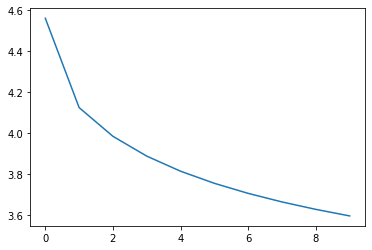

In [38]:
plt.plot(all_losses)

In [39]:
def find_similar(target_embedding, embedding_matrix, k):
    return embedding_matrix.matmul(target_embedding).argsort()[-k:].tolist()

def find_similar_words(word, embedding_matrix, k, name_to_index, index_to_name):
    target_embedding = cbow_model.embedding_matrix[name_to_index[word]]
    similar_indexes = find_similar(target_embedding, embedding_matrix, k=10)
    return [index_to_name[x] for x in similar_indexes][::-1]

In [40]:
embedding_matrix = cbow_model.embedding_matrix

In [41]:
find_similar_words(
    'olive oil',
    embedding_matrix,
    k=10,
    index_to_name=index_to_name,
    name_to_index=name_to_index,
)

['olive oil',
 'extra-virgin olive oil',
 'extra virgin olive oil',
 'rapeseed oil',
 'olive or rapeseed oil',
 'risotto rice',
 'chestnuts',
 'pack all-butter shortcrust pastry',
 'good-quality olive oil',
 'olive oil or rapeseed oil']

In [42]:
find_similar_words(
    'red pepper',
    embedding_matrix,
    k=10,
    index_to_name=index_to_name,
    name_to_index=name_to_index,
)

['red pepper',
 'yellow pepper',
 'aubergine',
 'brown basmati rice',
 'thumb-sized piece ginger',
 'green pepper',
 'mangetout',
 'carrot',
 'ground cumin',
 'vegetable bouillon powder']

In [43]:
find_similar_words(
    'milk',
    embedding_matrix,
    k=10,
    index_to_name=index_to_name,
    name_to_index=name_to_index,
)

['milk',
 'whole milk',
 'rapeseed or sunflower oil',
 'gluten-free baking powder',
 'semi-skimmed milk',
 'zest 1 lemon',
 'full-fat milk',
 'whipping cream',
 'eating apple',
 'kg floury potatoes']